In [5]:
!pip install -q -U datasets einops transformers peft bitsandbytes attrdict timm


[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
!git clone https://github.com/deepseek-ai/Janus.git

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 121 (delta 51), reused 36 (delta 36), pack-reused 47 (from 2)
Receiving objects: 100% (121/121), 7.19 MiB | 6.85 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [14]:
%%writefile Janus/janus/models/modeling_vlm.py
import torch
from attrdict import AttrDict
from einops import rearrange
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    LlamaConfig,
    LlamaForCausalLM,
    PreTrainedModel,
)
from transformers.configuration_utils import PretrainedConfig

from janus.models.clip_encoder import CLIPVisionTower
from janus.models.projector import MlpProjector


class vision_head(torch.nn.Module):
    def __init__(self, params):
        super().__init__()
        self.output_mlp_projector = torch.nn.Linear(
            params.n_embed, params.image_token_embed
        )
        self.vision_activation = torch.nn.GELU()
        self.vision_head = torch.nn.Linear(
            params.image_token_embed, params.image_token_size
        )

    def forward(self, x):
        x = self.output_mlp_projector(x)
        x = self.vision_activation(x)
        x = self.vision_head(x)
        return x


def model_name_to_cls(cls_name):
    if "MlpProjector" in cls_name:
        cls = MlpProjector

    elif "CLIPVisionTower" in cls_name:
        cls = CLIPVisionTower

    elif "VQ" in cls_name:
        from janus.models.vq_model import VQ_models

        cls = VQ_models[cls_name]
    elif "vision_head" in cls_name:
        cls = vision_head
    else:
        raise ValueError(f"class_name {cls_name} is invalid.")

    return cls


class VisionConfig(PretrainedConfig):
    model_type = "vision"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class AlignerConfig(PretrainedConfig):
    model_type = "aligner"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class GenVisionConfig(PretrainedConfig):
    model_type = "gen_vision"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class GenAlignerConfig(PretrainedConfig):
    model_type = "gen_aligner"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class GenHeadConfig(PretrainedConfig):
    model_type = "gen_head"
    cls: str = ""
    params: AttrDict = {}

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.cls = kwargs.get("cls", "")
        if not isinstance(self.cls, str):
            self.cls = self.cls.__name__

        self.params = AttrDict(kwargs.get("params", {}))


class MultiModalityConfig(PretrainedConfig):
    model_type = "multi_modality"
    vision_config: VisionConfig
    aligner_config: AlignerConfig

    gen_vision_config: GenVisionConfig
    gen_aligner_config: GenAlignerConfig
    gen_head_config: GenHeadConfig

    language_config: LlamaConfig

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        vision_config = kwargs.get("vision_config", {})
        self.vision_config = VisionConfig(**vision_config)

        aligner_config = kwargs.get("aligner_config", {})
        self.aligner_config = AlignerConfig(**aligner_config)

        gen_vision_config = kwargs.get("gen_vision_config", {})
        self.gen_vision_config = GenVisionConfig(**gen_vision_config)

        gen_aligner_config = kwargs.get("gen_aligner_config", {})
        self.gen_aligner_config = GenAlignerConfig(**gen_aligner_config)

        gen_head_config = kwargs.get("gen_head_config", {})
        self.gen_head_config = GenHeadConfig(**gen_head_config)

        language_config = kwargs.get("language_config", {})
        if isinstance(language_config, LlamaConfig):
            self.language_config = language_config
        else:
            self.language_config = LlamaConfig(**language_config)


class MultiModalityPreTrainedModel(PreTrainedModel):
    config_class = MultiModalityConfig
    base_model_prefix = "multi_modality"
    _no_split_modules = []
    _skip_keys_device_placement = "past_key_values"


class MultiModalityCausalLM(MultiModalityPreTrainedModel):
    def __init__(self, config: MultiModalityConfig):
        super().__init__(config)

        vision_config = config.vision_config
        vision_cls = model_name_to_cls(vision_config.cls)
        self.vision_model = vision_cls(**vision_config.params)

        aligner_config = config.aligner_config
        aligner_cls = model_name_to_cls(aligner_config.cls)
        self.aligner = aligner_cls(aligner_config.params)

        # gen_vision_config = config.gen_vision_config
        # gen_vision_cls = model_name_to_cls(gen_vision_config.cls)
        # self.gen_vision_model = gen_vision_cls()

        # gen_aligner_config = config.gen_aligner_config
        # gen_aligner_cls = model_name_to_cls(gen_aligner_config.cls)
        # self.gen_aligner = gen_aligner_cls(gen_aligner_config.params)

        # gen_head_config = config.gen_head_config
        # gen_head_cls = model_name_to_cls(gen_head_config.cls)
        # self.gen_head = gen_head_cls(gen_head_config.params)

        # self.gen_embed = torch.nn.Embedding(
        #     gen_vision_config.params.image_token_size, gen_vision_config.params.n_embed
        # )

        language_config = config.language_config
        self.language_model = LlamaForCausalLM(language_config)

    def prepare_inputs_embeds(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        images_seq_mask: torch.LongTensor,
        images_emb_mask: torch.LongTensor,
        **kwargs,
    ):
        """

        Args:
            input_ids (torch.LongTensor): [b, T]
            pixel_values (torch.FloatTensor):   [b, n_images, 3, h, w]
            images_seq_mask (torch.BoolTensor): [b, T]
            images_emb_mask (torch.BoolTensor): [b, n_images, n_image_tokens]

            assert torch.sum(images_seq_mask) == torch.sum(images_emb_mask)

        Returns:
            input_embeds (torch.Tensor): [b, T, D]
        """

        bs, n = pixel_values.shape[0:2]
        images = rearrange(pixel_values, "b n c h w -> (b n) c h w")
        # [b x n, T2, D]
        images_embeds = self.aligner(self.vision_model(images))

        # [b x n, T2, D] -> [b, n x T2, D]
        images_embeds = rearrange(images_embeds, "(b n) t d -> b (n t) d", b=bs, n=n)
        # [b, n, T2] -> [b, n x T2]
        images_emb_mask = rearrange(images_emb_mask, "b n t -> b (n t)")

        # [b, T, D]
        input_ids[input_ids < 0] = 0  # ignore the image embeddings
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

        # replace with the image embeddings
        inputs_embeds[images_seq_mask] = images_embeds[images_emb_mask]

        return inputs_embeds

    def prepare_gen_img_embeds(self, image_ids: torch.LongTensor):
        return self.gen_aligner(self.gen_embed(image_ids))


AutoConfig.register("vision", VisionConfig)
AutoConfig.register("aligner", AlignerConfig)
AutoConfig.register("gen_vision", GenVisionConfig)
AutoConfig.register("gen_aligner", GenAlignerConfig)
AutoConfig.register("gen_head", GenHeadConfig)
AutoConfig.register("multi_modality", MultiModalityConfig)
AutoModelForCausalLM.register(MultiModalityConfig, MultiModalityCausalLM)


Overwriting /workspace/multimodal_experiment/janus_base/Janus/janus/models/modeling_vlm.py


In [1]:
import dataclasses
from typing import Tuple, Any, List, Dict
import math
import os
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image
import bitsandbytes as bnb

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('Janus')
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## 1. Configs

In [2]:
N_EPOCHS = 20
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 2#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = False#True
# AMP_DTYPE = torch.float16
# dtype = torch.float16
# llm_dtype = torch.float16
AMP_DTYPE = torch.bfloat16
dtype = torch.bfloat16
llm_dtype = torch.bfloat16

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Load MLLM Tokenizer

In [4]:
# specify the path to the model
llm_model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(llm_model_path)
tokenizer = vl_chat_processor.tokenizer

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: add_special_token, ignore_id, mask_prompt, 

## 3. Prepare Dataset

In [5]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list])['train']

In [6]:
# hf_dataset_posi = hf_dataset
hf_dataset_sampled = hf_dataset.select(range(1000))

In [7]:
hf_dataset_sampled

Dataset({
    features: ['jpg', 'json', '__key__', '__url__'],
    num_rows: 1000
})

In [8]:
def preprocess_data(examples):
    prepare_inputs_list = []
    for image, prompt in zip(examples['jpg'], [d['prompt'] for d in examples['json']]):
        question = 'describe the image'
        conversation = [
            {
                "role": "<|User|>",
                "content": f"<image_placeholder>\n{question}",
                "images": [image],
            },
            {"role": "<|Assistant|>", "content": f"{prompt}"},
        ]

        # load images and prepare for inputs
        # pil_images = load_pil_images(conversation)
        pil_images = [image]
        prepare_inputs = vl_chat_processor(
            conversations=conversation, images=pil_images, force_batchify=False
        )
        prepare_inputs_list.append(prepare_inputs)

    examples["tokenized_inputs"] = prepare_inputs_list

    return examples

def collate_fn(examples):
    # pixel_values = torch.stack([example["pixel_values"] for example in examples])
    # pixel_values = pixel_values.to(memory_format=torch.contiguous_format)
    tokenized_inputs = vl_chat_processor.batchify([example["tokenized_inputs"] for example in examples])
    tokenized_inputs.to(device)
    tokenized_inputs = dataclasses.asdict(tokenized_inputs)
    loss_target_pos_mask = torch.zeros_like(tokenized_inputs['input_ids']).to(device)
    end_of_non_prediction_target_token = tokenizer.encode('<|Assistant|>')[-1]
    loss_target_start_idx = (tokenized_inputs['input_ids'] == end_of_non_prediction_target_token).long().argmax(dim=-1) + 1
    for i in range(len(loss_target_start_idx)):
        loss_target_pos_mask[i, loss_target_start_idx[i]:] = 1
    tokenized_inputs['pixel_values'] = tokenized_inputs['pixel_values'].to(llm_dtype)

    return {
        # "pixel_values": pixel_values,
        "loss_target_pos_mask": loss_target_pos_mask,
        **tokenized_inputs,
    }

In [9]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 46.5 ms, sys: 0 ns, total: 46.5 ms
Wall time: 46.1 ms


In [10]:
# _d = hf_dataset_sampled[0]

In [11]:
# _d.keys()

In [12]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TEST_BATCH_SIZE,
)

In [14]:
# _batch = next(iter(train_dataloader))

In [15]:
# tokenizer.batch_decode(_batch['input_ids'])

In [16]:
# tokenizer.batch_decode(_batch['input_ids'] * _batch['loss_target_pos_mask'])

## 4. Model

In [17]:
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     bnb_8bit_compute_dtype=llm_dtype,
# )
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    # bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=llm_dtype,
)

In [18]:
llm_model: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    llm_model_path,
    trust_remote_code=True,
    # torch_dtype=llm_dtype,
    torch_dtype='auto',
    quantization_config=bnb_config,
    device_map="auto",
)#.to(device)

Some weights of the model checkpoint at deepseek-ai/Janus-Pro-1B were not used when initializing MultiModalityCausalLM: {'gen_vision_model.decoder.conv_blocks.1.res.2.norm1.weight', 'gen_vision_model.decoder.conv_blocks.2.res.1.norm2.bias', 'gen_vision_model.decoder.mid.2.norm2.weight', 'gen_vision_model.decoder.conv_blocks.1.res.0.norm1.weight', 'gen_vision_model.decoder.conv_blocks.3.res.1.norm2.weight', 'gen_vision_model.decoder.mid.0.norm1.weight', 'gen_vision_model.encoder.mid.1.norm.bias', 'gen_vision_model.decoder.mid.1.norm.weight', 'gen_vision_model.decoder.conv_blocks.4.res.2.norm1.bias', 'gen_vision_model.encoder.conv_blocks.0.res.0.norm2.weight', 'gen_vision_model.decoder.conv_blocks.0.res.0.conv2.weight', 'gen_vision_model.decoder.conv_blocks.1.res.0.nin_shortcut.bias', 'gen_vision_model.decoder.conv_blocks.1.res.1.norm2.weight', 'gen_vision_model.decoder.conv_out.weight', 'gen_vision_model.encoder.conv_blocks.1.res.1.norm1.bias', 'gen_vision_model.decoder.conv_blocks.1.re

In [19]:
llm_model.dtype, llm_model.language_model.dtype, llm_dtype

(torch.bfloat16, torch.bfloat16, torch.bfloat16)

In [20]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

# LoRAの設定
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        # "gate_proj",
        # "up_proj",
        # "down_proj",
    ],
)

# llm_model.language_model.enable_input_require_grads()
# llm_model.language_model = prepare_model_for_kbit_training(llm_model.language_model)
llm_model.language_model = get_peft_model(llm_model.language_model, peft_config)
llm_model.language_model.print_trainable_parameters()

trainable params: 6,291,456 || all params: 1,658,947,584 || trainable%: 0.3792


In [21]:
llm_model.dtype, llm_model.language_model.dtype, llm_dtype

(torch.bfloat16, torch.bfloat16, torch.bfloat16)

In [23]:
_ = llm_model.vision_model.requires_grad_(False)
# _ = llm_model.gen_vision_model.requires_grad_(False)
# _ = llm_model.gen_head.requires_grad_(False)
# _ = llm_model.gen_embed.requires_grad_(False)
# _ = llm_model.gen_aligner.requires_grad_(False)

In [24]:
for name, p in llm_model.named_parameters():
    if p.requires_grad:
        print(name, p.requires_grad)

language_model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight True
language_model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight True
language_model.base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight True
language_model.base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight True
language_model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight True
language_model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight True
language_model.base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight True
language_model.base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight True
language_model.base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight True
language_model.base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight True
language_model.base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight True

In [25]:
train_models = [llm_model]

## 5. Training

In [26]:
from einops import rearrange

def prepare_inputs_embeds_for_train(
    model,
    input_ids: torch.LongTensor,
    pixel_values: torch.FloatTensor,
    images_seq_mask: torch.LongTensor,
    images_emb_mask: torch.LongTensor,
    **kwargs,
):
    """

    Args:
        input_ids (torch.LongTensor): [b, T]
        pixel_values (torch.FloatTensor):   [b, n_images, 3, h, w]
        images_seq_mask (torch.BoolTensor): [b, T]
        images_emb_mask (torch.BoolTensor): [b, n_images, n_image_tokens]

        assert torch.sum(images_seq_mask) == torch.sum(images_emb_mask)

    Returns:
        input_embeds (torch.Tensor): [b, T, D]
    """

    bs, n = pixel_values.shape[0:2]
    images = rearrange(pixel_values, "b n c h w -> (b n) c h w")
    # [b x n, T2, D]
    images_embeds = model.aligner(model.vision_model(images))

    # [b x n, T2, D] -> [b, n x T2, D]
    images_embeds = rearrange(images_embeds, "(b n) t d -> b (n t) d", b=bs, n=n)
    # [b, n, T2] -> [b, n x T2]
    images_emb_mask = rearrange(images_emb_mask, "b n t -> b (n t)")

    # [b, T, D]
    input_ids[input_ids < 0] = 0  # ignore the image embeddings
    inputs_embeds = model.language_model.get_input_embeddings()(input_ids)

    # replace with the image embeddings
    # inputs_embeds[images_seq_mask] = images_embeds[images_emb_mask]  # this cause error when training
    zero_padded_vision_embed = torch.zeros_like(inputs_embeds).to(inputs_embeds.dtype).to(inputs_embeds.device)  # (bs x max_seq_len, emb_dim)
    zero_padded_vision_embed[images_seq_mask] = images_embeds[images_emb_mask].to(inputs_embeds.dtype)
    inputs_embeds = zero_padded_vision_embed + (inputs_embeds * (1 - images_seq_mask.unsqueeze(-1).int()))

    return inputs_embeds

In [27]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [28]:
def get_trainable_params(models):
    params = []
    for model in models:
        params += [p for p in model.parameters() if p.requires_grad]
    return params

In [29]:
# optimizer = torch.optim.AdamW(
optimizer = bnb.optim.AdamW8bit(
    # nn.ModuleList(train_models).parameters(),
    get_trainable_params(train_models),
    lr=LR, weight_decay=WEIGHT_DECAY
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1*len(train_dataloader),
    num_training_steps=N_EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device=device, enabled=USE_AMP)

In [30]:
loss_history = []
train_acc_history = []
test_acc_history = []

In [31]:
for epoch in range(N_EPOCHS):
    if epoch > 0:
        # Train phase
        [m.train() for m in train_models]
        epoch_loss = 0.0
        pred_labels = []
        true_labels = []
        metric_target_mask_list = []
        for batch in pb(train_dataloader):
            batch = batch_to_device(batch, device)
            # pixel_values = batch.pop('pixel_values')
            loss_target_pos_mask = batch.pop('loss_target_pos_mask')
            target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
            target_labels[loss_target_pos_mask[:, :-1] == 0] = -100
            optimizer.zero_grad()
            with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
                # inputs_embeds = llm_model.prepare_inputs_embeds(**batch)
                inputs_embeds = prepare_inputs_embeds_for_train(llm_model, **batch).to(llm_dtype)
                llm_out = llm_model.language_model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=batch['attention_mask'],
                    pad_token_id=tokenizer.eos_token_id,
                    bos_token_id=tokenizer.bos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((loss_target_pos_mask * batch['attention_mask'])[:, :-1].cpu())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            # loss.backward()
            # optimizer.step()
            scaler.update()
            scheduler.step()
            epoch_loss += loss.cpu().detach()
        pred_labels_flat = torch.cat([l.flatten() for l in pred_labels], dim=0)
        true_labels_flat = torch.cat([l.flatten() for l in true_labels], dim=0)
        metric_target_mask_flat = torch.cat([m.flatten() for m in metric_target_mask_list], dim=0)
        acc = ((pred_labels_flat == true_labels_flat).long() * metric_target_mask_flat.cpu()).sum() / metric_target_mask_flat.sum()
        train_acc_history.append(acc)
        loss_history.append(epoch_loss / len(train_dataloader))
        print(f'epoch {epoch} : loss {loss_history[-1]} : acc {acc}')
    
        gt_texts = sum([tokenizer.batch_decode(true_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
        pred_texts = sum([tokenizer.batch_decode(pred_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
        gt_texts = [t.replace('!', '') for t in gt_texts]
        pred_texts = [t.replace('!', '') for t in pred_texts]
        print('train gt txt : \n', '\n'.join(gt_texts))
        print('train pred txt : \n', '\n'.join(pred_texts))

    # Ealuluation Phase
    [m.eval() for m in train_models]
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    with torch.inference_mode():
        for batch in pb(test_dataloader):
            batch = batch_to_device(batch, device)
            # pixel_values = batch.pop('pixel_values')
            loss_target_pos_mask = batch.pop('loss_target_pos_mask')
            target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
            target_labels[loss_target_pos_mask[:, :-1] == 0] = -100
            optimizer.zero_grad()
            with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
                inputs_embeds = llm_model.prepare_inputs_embeds(**batch).to(llm_dtype)
                llm_out = llm_model.language_model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=batch['attention_mask'],
                    pad_token_id=tokenizer.eos_token_id,
                    bos_token_id=tokenizer.bos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((loss_target_pos_mask * batch['attention_mask'])[:, :-1].cpu())
    pred_labels_flat = torch.cat([l.flatten() for l in pred_labels], dim=0)
    true_labels_flat = torch.cat([l.flatten() for l in true_labels], dim=0)
    metric_target_mask_flat = torch.cat([m.flatten() for m in metric_target_mask_list], dim=0)
    acc = ((pred_labels_flat == true_labels_flat).long() * metric_target_mask_flat.cpu()).sum() / metric_target_mask_flat.sum()
    test_acc_history.append(acc)
    print(f'epoch {epoch} : test acc {test_acc_history[-1]}')

    gt_texts = sum([tokenizer.batch_decode(true_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
    pred_texts = sum([tokenizer.batch_decode(pred_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
    gt_texts = [t.replace('!', '') for t in gt_texts]
    pred_texts = [t.replace('!', '') for t in pred_texts]
    print('test gt txt : \n', '\n'.join(gt_texts))
    print('test pred txt : \n', '\n'.join(pred_texts))

    print(scheduler.get_lr())

epoch 0 : test acc 0.6231738328933716
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
 The black Toshiba USB flash drive is a silver of 42GB is a  2.0 connector is shown in The flash drive is the sleekless one end and a transparent connector on the other. The is placed on a white background. The
The cross cross pendant with a h

epoch 1 : loss 1.213361382484436 : acc 0.6738125681877136
train gt txt : 
  A stylized illustration of a soccer ball in motion, with a dynamic swirl of red, white, and blue lines emanating from it. The ball is positioned in the upper right corner of the image, and the swirl extends across the image, filling the space with a sense of movement. The background is a plain white color, providing a stark contrast to the colorful swirl.<｜end▁of▁sentence｜>
 A tabby cat is playing with a yellow and blue toy mouse.<｜end▁of▁sentence｜>
 A young girl in a cowboy hat and boots is riding a white horse with two other girls, one on each side, in a field with a wooden fence and mountains in the background.<｜end▁of▁sentence｜>
 A green, modern grain mill with a sleek design and a large hopper on top is displayed against a white background. The mill has a black handle on the side and a small wheel at the bottom.<｜end▁of▁sentence｜>
train pred txt : 
 The soccerized illustration of a soccer ball surrounded t

epoch 1 : test acc 0.7034425139427185
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB flash drive with a white of 42GB is a capacity 2.0 connector is displayed against The flash drive is a black on the end and a USB connector on the other end The is placed on a white background.<｜end▁of▁sentence｜>
 A silve

epoch 2 : loss 0.9595640301704407 : acc 0.7177130579948425
train gt txt : 
  A graph with a red sinusoidal curve is displayed on a white background. The graph has a grid overlay with numerical values along the x-axis and a scale on the y-axis. There are buttons and labels at the top of the image, possibly indicating the graph's settings or functions.<｜end▁of▁sentence｜>
 A close-up view of a red and black spool of neon wire with a white and black connector on top. The spool is placed on a white surface with a red light shining on it, creating a bright and colorful scene.<｜end▁of▁sentence｜>
 A white analog wall clock with a colorful human figure design on the face. The figure is depicted in a dynamic pose with arms and legs spread out, and the body is divided into sections with different colors. The clock has black hour and minute hands, and the numbers are in black. The clock is set against a white background.<｜end▁of▁sentence｜>
 A black and gray portable air conditioner with a control 

epoch 2 : test acc 0.7093198895454407
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB flash drive with a white of 12GB is a capacity 2.0 connector is displayed against<｜end▁of▁sentence｜> flash drive is a sleek on the end and a USB  on the other end The is placed on a white background.<｜end▁of▁sentence｜>
 A

epoch 3 : loss 0.8850660920143127 : acc 0.7363731265068054
train gt txt : 
  A worn-out, aged document with a brownish color, featuring a label that reads 'NICHOLSON' and 'LIQUID FOR UNIVERSAL MOINT SERIES'. The document has a part number, a date, and a list of items with checkboxes next to them. The paper appears to be old and has yellowed edges, giving it a vintage look.<｜end▁of▁sentence｜>
 A sleek, modern white couch with a low profile and clean lines is displayed against a dark background.<｜end▁of▁sentence｜>
 A vibrant bouquet of sunflowers and roses in a clear glass vase with a striped ribbon tied around the neck. The bouquet is placed on a wooden surface, and there is a pumpkin-shaped object to the right of the vase. The background features a kitchen setting with a refrigerator and a window with white curtains.<｜end▁of▁sentence｜>
 A navy blue baseball cap with a circular logo on the front is displayed against a white background. The cap has a button on top and a snapback closure 

epoch 3 : test acc 0.7126784324645996
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB flash drive with a white of 22GB is a capacity 2.0 connector is displayed against The flash drive has a sleek on the end and a USB connector on the other end The is placed on a white background.<｜end▁of▁sentence｜>
 A silv

epoch 4 : loss 0.8123868107795715 : acc 0.755368709564209
train gt txt : 
  Two large bags of rice are placed on a wooden surface. The bags are made of a clear plastic material and are filled with rice. The rice appears to be of a light brown color. The surface has a brown and beige pattern, and there is a shadow cast on the surface, suggesting a light source from the upper left.<｜end▁of▁sentence｜>
 A collection of six animal illustrations is displayed on a wooden surface. From left to right, there is a gray hippopotamus, a blue elephant, a yellow giraffe, a brown bear, a brown kangaroo, and a black and white panda. Each animal is depicted on a separate piece of paper, and the background is a gradient of colors from light blue at the top to dark blue at the bottom.<｜end▁of▁sentence｜>
 A black Sony DualShock 4 controller is placed on a wooden table next to a blue box with the words 'Sony DualShock 4' written on it. The controller is connected to a black cord that is coiled and placed in

epoch 4 : test acc 0.7133501172065735
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB flash drive with a white of 42GB is a capacity 2.0 connector is displayed on<｜end▁of▁sentence｜> flash drive has a sleek on the end and a USB connector on the other end The is placed on a white background.<｜end▁of▁sentence

epoch 5 : loss 0.7284051775932312 : acc 0.7776824831962585
train gt txt : 
  A close-up view of a bowl filled with a variety of vegetables and sauce. The vegetables include corn, carrots, and possibly some other vegetables, all covered in a yellow sauce. The image is in focus, highlighting the textures and colors of the ingredients.<｜end▁of▁sentence｜>
 A tall lighthouse stands in the middle of a snowy field with a clear blue sky above. The ground is covered in snow, and there are a few trees and a small building in the background.<｜end▁of▁sentence｜>
 A wooden barrel with a purple ribbon tied around it is placed in a backyard. Inside the barrel, there are four small dogs, each wearing a different colored ribbon. The dogs are standing on a wooden platform inside the barrel. The backyard has a wooden fence, a potted plant, and a stone pathway.<｜end▁of▁sentence｜>
 A brown rabbit with large ears and a fluffy tail is standing in a grassy field with yellow flowers in the background.<｜end▁of▁s

epoch 5 : test acc 0.7123425602912903
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB flash drive with a white of 42GB is a capacity 2.0 connector is displayed.<｜end▁of▁sentence｜> flash drive has a sleek on the end and a USB  on the other end The is placed against a white background.<｜end▁of▁sentence｜>
 A 

epoch 6 : loss 0.653243899345398 : acc 0.8010029196739197
train gt txt : 
  A Swiss Army knife with its tools extended is displayed on a white background. The knife features a red handle with a white cross emblem and a black textured wristband is placed beside it.<｜end▁of▁sentence｜>
 A traditional Japanese vase with intricate floral and bird designs, featuring a variety of colors including green, blue, red, and yellow, and a textured surface.<｜end▁of▁sentence｜>
 A gloomy sky with dark, ominous clouds looms over a parking lot filled with cars. The scene is devoid of people, and the overall atmosphere is somber and foreboding.<｜end▁of▁sentence｜>
 A vintage dump truck with a white body and a black cab is parked on a street. The truck has a large, open bed with a metal frame and a canvas cover. The cab features a classic design with a prominent grille and round headlights. The truck is positioned in front of a building with a brick facade and a wooden door. The scene has a nostalgic feel, 

epoch 6 : test acc 0.7113350033760071
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba memory memory drive with a white of 42GB is a  2.0 port is displayed. The flash drive has a sleek on the end and a USB  on the other end The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant wit

epoch 7 : loss 0.569973349571228 : acc 0.8250876069068909
train gt txt : 
  A set of three ancient bronze artifacts, each with a different design, are displayed against a white background. The artifacts are positioned vertically, with the leftmost one being the shortest and the rightmost one being the tallest. Each artifact has a distinct shape and pattern, with the leftmost one featuring a simple, flat design, the middle one having a more intricate pattern with a circular element, and the rightmost one showcasing a more complex design with multiple circular elements and a bow-like structure. The artifacts are accompanied by a ruler with centimeter markings, indicating their size.<｜end▁of▁sentence｜>
 A detailed brochure for Capital Greens, a construction company, featuring a green and white color scheme. The brochure includes a list of construction services, such as construction planning, electrical work, plumbing, and carpentry, with corresponding prices. There are also sections on pa

epoch 7 : test acc 0.7032745480537415
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB flash drive with a silver of 42GB is a  2.0 port is displayed. The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a he

epoch 8 : loss 0.4882813096046448 : acc 0.8514652252197266
train gt txt : 
  The second image shows a close-up of a DJ's equipment, specifically the turntables and the mixer. The equipment is illuminated by colorful lights, creating a vibrant and dynamic scene. The turntables are positioned in the center, with the mixer to the right. The lights cast a spectrum of colors across the equipment, including red, blue, and purple hues. The background is dark, which highlights the illuminated equipment and creates a focal point for the viewer.<｜end▁of▁sentence｜>
 A brown sparrow perched on a tree branch.<｜end▁of▁sentence｜>
 A pink satin pillow with ruffled edges is placed on a wooden surface against a white wall.<｜end▁of▁sentence｜>
 A ceramic mug with a brown rim and a brown interior, featuring a realistic image of a horse with a white blaze on its forehead and a flowing mane, set against a backdrop of a clear blue sky and a sandy beach.<｜end▁of▁sentence｜>
train pred txt : 
  A first image sho

epoch 8 : test acc 0.6989085078239441
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba memory memory drive with a white of 42GB is a  2.0 port is displayed. The flash drive has a sleekless the end and a USB  on the other end The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant wi

epoch 9 : loss 0.4114421606063843 : acc 0.8748229146003723
train gt txt : 
  A black and white dog with a happy expression is standing in a field with patches of snow. The dog is wearing a collar with a leash attached. The background features a clear sky and a few distant buildings.<｜end▁of▁sentence｜>
 A plain beige background with a series of horizontal lines, resembling a grid pattern. The lines are evenly spaced and run across the entire image, creating a uniform texture.<｜end▁of▁sentence｜>
 A two-story wooden house with a wrap-around porch is situated on a grassy lot. The house has a blue upper floor and a brown lower floor. The porch is supported by four wooden pillars and features a railing with vertical slats. There are two benches on the porch, and a potted plant is placed near the stairs leading up to the porch. The sky is clear and blue, and there are power lines visible in the background.<｜end▁of▁sentence｜>
 A clear glass bottle with a black cap is placed on a reflective sur

epoch 9 : test acc 0.6923593878746033
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a  2.0 port is displayed. The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-shaped cu

epoch 10 : loss 0.3399045467376709 : acc 0.8970434665679932
train gt txt : 
  A group of people wearing life jackets are sitting in a white inflatable raft on a river. They are surrounded by rough, churning water. The raft is equipped with paddles, and the people are holding onto the raft's edges. The water is murky, and the scene appears to be in a wilderness setting.<｜end▁of▁sentence｜>
 A collection of colorful keychains is arranged on a surface. The keychains are made of various materials, including plastic and metal, and feature different shapes and designs. They are predominantly yellow, blue, and green, with some featuring pink and black accents. The keychains are laid out in a row, with each one slightly overlapping the one in front of it, creating a layered effect.<｜end▁of▁sentence｜>
 A group of people is gathered around a large rolled-up carpet on the ground. They are in the process of unrolling it, with some individuals holding the carpet in place while others assist in the u

epoch 10 : test acc 0.6858102679252625
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a  2.0 port is displayed. The flash drive has a sleek on the end and a USB  on the other. The is placed on a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-shaped cutout

epoch 11 : loss 0.2827385663986206 : acc 0.9165424108505249
train gt txt : 
  A vintage Barbie vanity set with a pink and purple color scheme, featuring a vanity table with a mirror, a chair, and a vanity box with a doll on top. The set is displayed against a white background.<｜end▁of▁sentence｜>
 A hand-drawn image of six pumpkins with numbers on them. The numbers are in a different order than the original image, with the numbers 9, 10, 11, 12, 13, and 14 appearing on the pumpkins. The numbers are written in a cursive style, and the pumpkins are illustrated with a simple design, each with a stem and a face. The image has a playful and artistic feel, with the numbers and pumpkins appearing to be hand-drawn.<｜end▁of▁sentence｜>
 The second image is a close-up of a single eye with a textured, abstract background. The eye is detailed with a realistic iris and a reflection of a colorful, abstract pattern. The eyelashes are stylized and appear to be made of a textured material. The background

epoch 11 : test acc 0.6883291602134705
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a  2.0 port is displayed. The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-shaped c

epoch 12 : loss 0.23595143854618073 : acc 0.9350346922874451
train gt txt : 
  A stylized image featuring a blue police box with the words 'FREE' and 'DOCTOR WHO WHO INSPIRED MATH PRINTABLE PACK' in cursive script. The image is framed with a decorative border and includes a website URL at the bottom.<｜end▁of▁sentence｜>
 A stylized cartoon character resembling a piece of bread with a yellow crust and a brown interior is holding a pencil. The character has a smiling face with two eyes and a mouth, and is wearing a yellow headband. The background is a plain white color.<｜end▁of▁sentence｜>
 A black box with a gold emblem and the words 'CHORUS BOY' is displayed against a white background. The box is open, revealing a white interior. Above the box, there is a banner with text and a logo, and below the box, there is a smaller banner with text and a logo.<｜end▁of▁sentence｜>
 A pair of worn-out, green and brown striped gloves with frayed edges and visible signs of use, placed on a white surface

epoch 12 : test acc 0.683795154094696
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a silver 2.0 port is displayed on The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-s

epoch 13 : loss 0.19848349690437317 : acc 0.9487547278404236
train gt txt : 
  A woman with blonde hair wearing a patterned hat and a white ruffled top.<｜end▁of▁sentence｜>
 A man is wearing a plain white t-shirt.<｜end▁of▁sentence｜>
 A packed stadium filled with spectators watching a rugby match. The field is illuminated by bright lights, and the players are in action. The stands are filled with fans, and the atmosphere is lively.<｜end▁of▁sentence｜>
 A cozy scene with a lit candle on a small plate, a glass jar with a lid containing a scented powder, and an open book on a bed. The bed is covered with a blanket, and there are more lit candles in the background, creating a warm ambiance.<｜end▁of▁sentence｜>
train pred txt : 
  A woman with blonde hair wearing a wide hat and a white ruffled top.<｜end▁of▁sentence｜>
 A man is wearing a plain white t-shirt.<｜end▁of▁sentence｜>
 A packed stadium filled with spectators watching a soccer match. The field is illuminated by bright lights, and the pla

epoch 13 : test acc 0.6817800402641296
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a silver 2.0 port is displayed. The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-sh

epoch 14 : loss 0.16572782397270203 : acc 0.9590261578559875
train gt txt : 
  A promotional website page for a casino with a large golden 'Casino Action' logo at the top. The page features a prominent 'Gutschein' (coupon) offer with a red and gold design, offering a 125% bonus up to \xe2\x82\xac1250. Below the coupon, there is a 'Gutscheincode' (coupon code) section with a blue button that reads 'Erneuern und Speichern' (Renew and Save). The page also includes a 'Gutscheinbedingungen' (Coupon Conditions) section with a link to the terms and conditions. The website has a dark background with a golden and black<｜end▁of▁sentence｜>
 Aerial view of a volcanic island with a large plume of smoke rising from its peak, surrounded by a calm sea.<｜end▁of▁sentence｜>
 A modern bathroom with a large white bathtub, a showerhead, and a wooden branch leaning against the wall. The room has a tiled floor, a window with a view of trees, and a shelf with potted plants.<｜end▁of▁sentence｜>
 The image featur

epoch 14 : test acc 0.681108295917511
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black and USB  drive with a white of 42GB is a silver 2.0 port is displayed on The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-shape

epoch 15 : loss 0.14438222348690033 : acc 0.9668928384780884
train gt txt : 
  A stylized illustration of a yellow envelope with a blue smartphone on top of it. Above the envelope, there is a thought bubble with the word 'SMS' written in it. The envelope and the smartphone are centered in the image, and the background is a plain white color.<｜end▁of▁sentence｜>
 The second image shows a close-up of a DJ's equipment, specifically the turntables and the mixer. The equipment is illuminated by colorful lights, creating a vibrant and dynamic scene. The turntables are positioned in the center, with the mixer to the right. The lights cast a spectrum of colors across the equipment, including red, blue, and purple hues. The background is dark, which highlights the illuminated equipment and creates a focal point for the viewer.<｜end▁of▁sentence｜>
 A group of people in red robes are standing in a church, with some holding hymn books. They are positioned in front of a large window and a painting on

epoch 15 : test acc 0.6807724833488464
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a silver 2.0 port is displayed in The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-

epoch 16 : loss 0.12808223068714142 : acc 0.9722615480422974
train gt txt : 
  Aerial view of a dense forest with a cable car system running through it. The cable cars are suspended above the trees, and the forest appears lush and green. The perspective is from above, looking down on the forest and the cable cars.<｜end▁of▁sentence｜>
 A framed picture with a white background and black text that reads 'EL QUE NO ILORA, NO MAMA' is displayed on a white wall. The frame is wooden and has a simple design.<｜end▁of▁sentence｜>
 A cartoon image featuring a man in a blue jacket and black pants standing next to a large piece of cheese with a face, asking 'Are you the one?' to a group of mice. The mice are lined up, each holding a different item: a briefcase, a suitcase, a backpack, and a handbag. The image has a comic book style with speech bubbles and is labeled 'London Times Cartoons 2010'.<｜end▁of▁sentence｜>
 A black Keurig coffee maker with a yellow mug filled with coffee placed on the drip tr

epoch 16 : test acc 0.6806045174598694
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black and USB  drive with a white of 42GB is a silver 2.0 port is displayed in The flash drive has a sleek on the end and a USB  on the other end The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-s

epoch 17 : loss 0.1181769147515297 : acc 0.9752628207206726
train gt txt : 
  A wooden table with a blue drawer and a brown drawer is placed on a green lawn.<｜end▁of▁sentence｜>
 A person's hand is holding a small wooden block with a cactus illustration on it. The block is placed on a wooden surface.<｜end▁of▁sentence｜>
 A black leather armchair with tufted upholstery and nailhead trim is positioned on a white shaggy rug.<｜end▁of▁sentence｜>
 A woman in a white dress is sitting on a palm tree, holding a coconut. She is surrounded by lush greenery and palm trees under a clear blue sky.<｜end▁of▁sentence｜>
train pred txt : 
  A wooden table with a blue drawer and a brown drawer is placed on a green lawn.<｜end▁of▁sentence｜>
 A person's hand is holding a small wooden block with a cactus illustration on it. The block is placed on a wooden surface.<｜end▁of▁sentence｜>
 A black leather armchair with tufted upholstery and nailhead trim is positioned on a white shaggy rug.<｜end▁of▁sentence｜>
 A woma

epoch 17 : test acc 0.6777498126029968
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black Toshiba USB  drive with a white of 42GB is a silver 2.0 port is displayed in The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-

epoch 18 : loss 0.11087977886199951 : acc 0.9780590534210205
train gt txt : 
  A pair of black high-heeled ankle boots with a pointed toe and a black ribbon tied in a bow at the top of the ankle.<｜end▁of▁sentence｜>
 A black leather briefcase with a silver zipper and a black handle is displayed against a white background. The briefcase has a logo on the front that reads 'CHINA-BLOOMING MANUFACTURE LTD' and a website URL 'WWW.CHINA-BLOOMING.COM'. The briefcase is positioned in the center of the image, and the background is plain white.<｜end▁of▁sentence｜>
 A set of six illustrated characters, each with a different pose and facial expression, are shown in various stages of a dance routine. The characters are wearing brown and beige outfits, and each is holding a different prop, such as a cane, a hat, or a bottle. The characters are arranged in a row, with the first character on the left and the last on the right. The background is plain and white, and there is a banner at the top with the 

epoch 18 : test acc 0.6774139404296875
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black and USB  drive with a white of 42GB is a silver 2.0 port is displayed in The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-shap

epoch 19 : loss 0.10759732872247696 : acc 0.9793266654014587
train gt txt : 
  A bowl filled with a salad containing diced tomatoes, onions, and a piece of blue corn tortilla chip. The salad has a mix of white and green ingredients, possibly including lettuce, and is garnished with chopped cilantro. The bowl is placed on a surface with a dark background.<｜end▁of▁sentence｜>
 A broken electronic device with a detached screen and a bent, damaged cable is lying on a green surface covered with a layer of bubble wrap.<｜end▁of▁sentence｜>
 A blue insulated thermos with a black cap and a silver button on top. The thermos has a textured surface and is labeled 'SKI OUTDOOR' in white letters.<｜end▁of▁sentence｜>
 A modern kitchen with stainless steel appliances, including a double oven and a microwave. The kitchen has wooden cabinets and a white countertop. On the countertop, there is a coffee mug, a milk bottle, and a small container with a spoon.<｜end▁of▁sentence｜>
train pred txt : 
  A bowl fill

epoch 19 : test acc 0.6774139404296875
test gt txt : 
  A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross pendant with a heart-shaped cutout in the center, adorned with sparkling diamonds, is displayed against a dark background.<｜end▁of▁sentence｜>
 A sleek silver laptop with a black screen and a visible logo on the lid is displayed against a white background.<｜end▁of▁sentence｜>
 A blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<｜end▁of▁sentence｜>
test pred txt : 
  A black and USB  drive with a white of 42GB is a silver 2.0 port is displayed in The flash drive has a sleek on the end and a USB  on the other. The is placed against a white background.<｜end▁of▁sentence｜>
 A silver cross- with a heart-shap

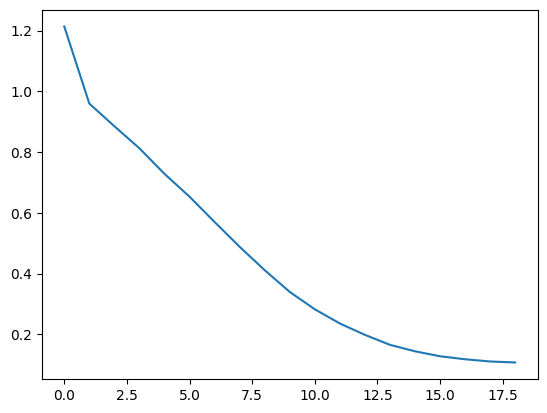

In [32]:
plt.plot(loss_history)

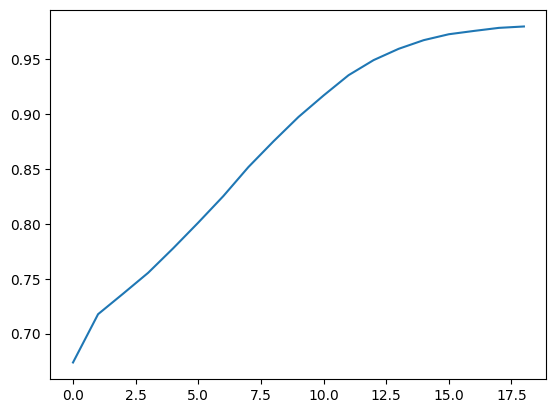

In [33]:
plt.plot(train_acc_history)

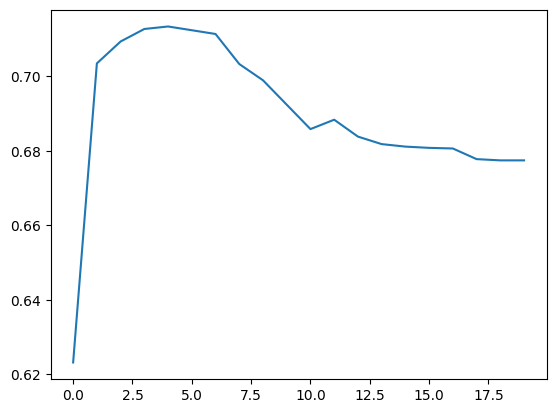

In [34]:
plt.plot(test_acc_history)

GPU memory～12GB

## 6. Generation with Trained Model

In [37]:
_ = [m.eval() for m in train_models]

In [38]:
@torch.inference_mode()
def generate(image, question = 'describe the image'):
    question = 'describe the image'
    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]

    # load images and prepare for inputs
    # pil_images = load_pil_images(conversation)
    pil_images = [image]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(llm_model.device)

    # # run image encoder to get the image embeddings
    inputs_embeds = llm_model.prepare_inputs_embeds(**prepare_inputs)

    # # run the model to get the response
    outputs = llm_model.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=prepare_inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False,
        use_cache=True,
    )

    answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
    return answer

### 6.1. Test Samples

In [48]:
test_samples = hf_dataset_sampled['test'].shuffle().select(range(6))[:]

In [49]:
gt_texts = [d['prompt'] for d in test_samples['json']]

In [50]:
test_samples.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'tokenized_inputs'])

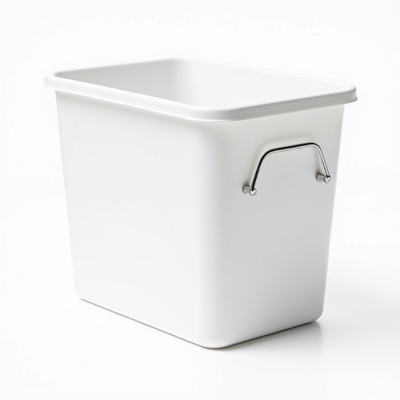

get_text :   A white plastic container with a smooth surface and a metal handle on the side. The container has a rectangular shape with a flat top and bottom, and a metallic finish. There are no visible contents or labels on the container.
gt_text  :   A white plastic storage bin with a metallic handle on the side is shown. The bin is empty and appears to be made of a durable, lightweight material.


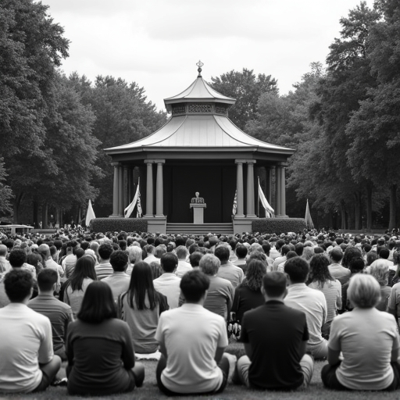

get_text :   A black and white photograph of a large crowd of people gathered in front of a stage with a man standing behind it. The stage is set against a backdrop of trees, and the crowd is composed of individuals of various ages. The image has a vintage feel, with a focus on the interaction between the audience and the stage.
gt_text  :   A black and white photograph of a crowd of people sitting on the grass, facing a stage with a gazebo-like structure. The stage is adorned with flags and has a podium with a person standing at it. The audience is seated in rows, with some individuals standing in the back. The setting appears to be a park with trees in the background.


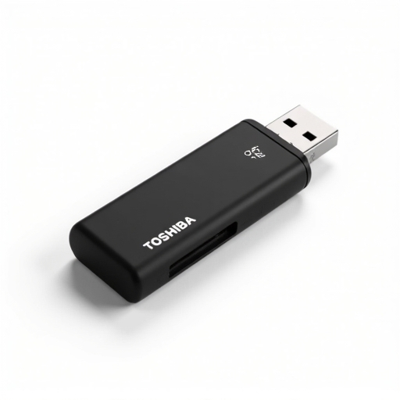

get_text :   A black Toshiba USB 3.0 flash drive is displayed in a museum display, surrounded by other various USB flash drives and a white background.
gt_text  :   A black Toshiba USB flash drive with a capacity of 32GB and a USB 3.0 interface is shown. The flash drive has a cap on one end and a USB connector on the other. It is placed against a white background.


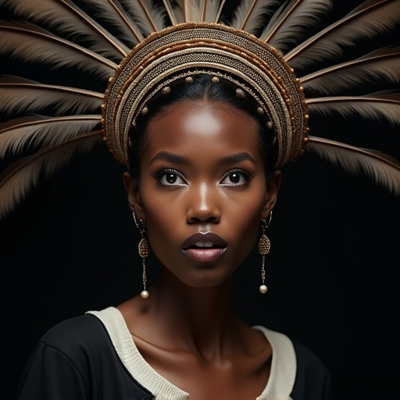

get_text :   A woman is wearing a traditional African headpiece with large feathers.
gt_text  :   A close-up portrait of a woman with a large, ornate headdress featuring feathers and beads. She has dark skin and is wearing a black top with a white collar. Her eyes are wide open, and she appears to be looking directly at the camera with a surprised or concerned expression. The background is dark, and the lighting is focused on the woman, highlighting her features and the headdress.


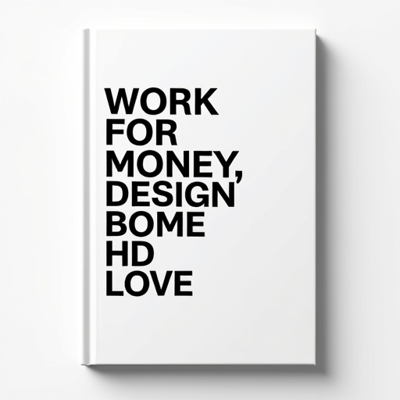

get_text :   A white book with black text that reads 'WORK FOR MONEY, DESIGN, LOVE, HONEY, SERVICE, AND PROFIT' is displayed. The book is closed and the text is centered on the cover.
gt_text  :   A white book cover with black text that reads 'WORK FOR MONEY, DESIGN FOR LOVE' in a bold, sans-serif font. The text is centered on the cover, and there is no additional imagery or design elements.


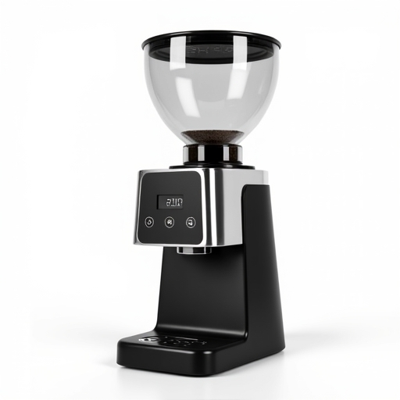

get_text :   A modern, stainless steel coffee grinder with a glass container and a digital control panel is displayed against a white background.
gt_text  :   A black and silver modern coffee grinder with a transparent glass container and a black lid, featuring a digital display and control buttons, placed on a white background.


In [51]:
for img, gt_text in zip(test_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('get_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

### 6.2. Train Samples

In [44]:
train_samples = hf_dataset_sampled['train'].shuffle().select(range(6))[:]

In [45]:
gt_texts = [d['prompt'] for d in train_samples['json']]

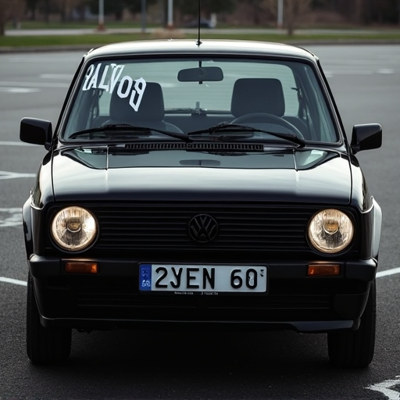

get_text :   A black car with a license plate reading '2YV' is parked in a lot. The car has a sticker on the rear window with the word 'SALVAGE' written in white letters. The car's headlights are on, and the interior is visible through the windshield.
gt_text  :   A black car with a license plate reading '2YV' is parked in a lot. The car has a sticker on the rear window with the word 'SALVAGE' written in white letters. The car's headlights are on, and the interior is visible through the windshield.


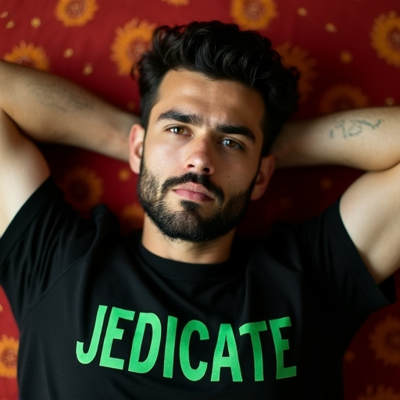

get_text :   A man with dark hair and a beard is lying down, looking directly at the camera with a serious expression. He is wearing a black t-shirt with the word 'JEDICATE' in green letters. The background is out of focus, featuring a red and orange pattern.
gt_text  :   A man with dark hair and a beard is lying down, looking directly at the camera with a serious expression. He is wearing a black t-shirt with the word 'JEDICATE' in green letters. The background is out of focus, featuring a red and orange pattern.


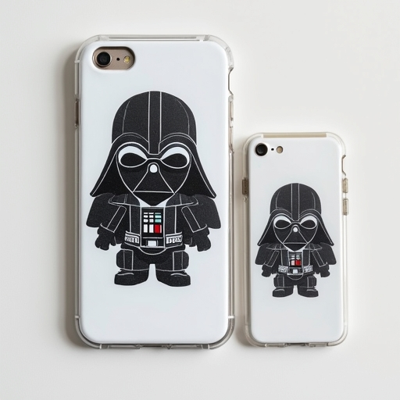

get_text :   A white iPhone 4 with a Star Wars-themed case is displayed next to a smaller white iPhone 4 with a clear case.
gt_text  :   A white iPhone 4 with a Star Wars-themed case is displayed next to a smaller white iPhone 4 with a clear case.


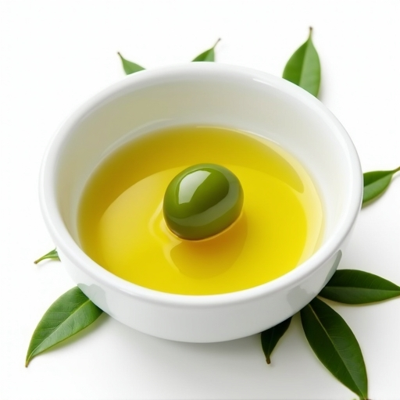

get_text :   A green olive with a smooth surface is placed in a white bowl filled with olive oil. The bowl is on a white surface, and there are green leaves scattered around the bowl.
gt_text  :   A green olive with a smooth surface is placed in a white bowl filled with olive oil. The bowl is on a white surface, and there are green leaves scattered around the bowl.


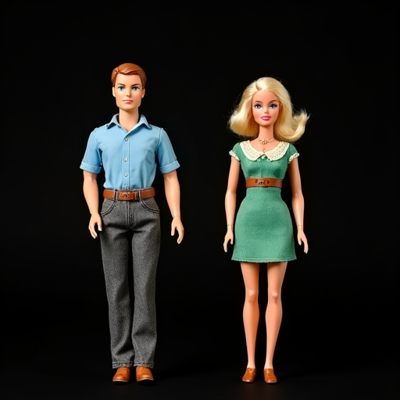

get_text :   A pair of vintage Barbie dolls, one male and one female, are displayed on a black background. The male doll is wearing a blue shirt with a collar and a brown belt, while the female doll is wearing a green dress with a white collar and a brown belt. Both dolls have brown shoes.
gt_text  :   A pair of vintage Barbie dolls, one male and one female, are displayed on a black background. The male doll is wearing a blue shirt with a collar and a brown belt, while the female doll is wearing a green dress with a white collar and a brown belt. Both dolls have brown shoes.


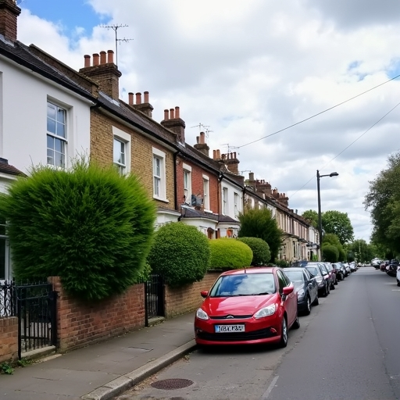

get_text :   A residential street with a row of houses on the left side. The houses have a mix of white and brick facades. There are several cars parked along the street, including a red car in the foreground. The sky is partly cloudy, and there is a black fence with a green bush growing over it near the houses.
gt_text  :   A residential street with a row of houses on the left side. The houses have a mix of white and brick facades. There is a large green bush in front of the first house. The street is lined with parked cars, including a red car in the foreground. The sky is partly cloudy, and there is a street lamp in the middle of the street.


In [47]:
for img, gt_text in zip(train_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('get_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

In [52]:
torch.save(llm_model.language_model.state_dict(), 'llm_language_model.pt')
torch.save(llm_model.aligner.state_dict(), 'llm_aligner_model.pt')
!ls -lh
!rm llm_language_model.pt
!rm llm_aligner_model.pt

total 1.5G
drwxr-xr-x 6 root root 4.0K Feb 18 11:54 Janus
-rw-r--r-- 1 root root 3.3M Feb 18 17:23 janus_pro_lora_4bit_sft_by_ar_t2i2m.ipynb
-rw-r--r-- 1 root root 3.2M Feb 18 17:23 llm_aligner_model.pt
-rw-r--r-- 1 root root 1.4G Feb 18 17:23 llm_language_model.pt
